Acces ORBIS database through Bocconi Library: https://unibocconi.libguides.com/az.php?a=o

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# orbis_raw.xlsx --> orbis.csv

Open the .xlxs files downloaded from Orbis and convert to single .csv

In [2]:
# df = pd.concat([
# pd.read_excel('./data/orbis_raw_1_15000.xlsx', sheet_name='Results', index_col=0),
# pd.read_excel('./data/orbis_raw_15001_31710.xlsx', sheet_name='Results', index_col=0)
# ], ignore_index=True)

# df.head()

Work on the single .csv

Create a new year columns and convert columns accordingly  
Years from 2017 to 2023 included.
Yearly columns:
- R&D expenses / Operating revenue\nYEAR
- Acquisition of Business\nm USD YEAR
- Operating revenue (Turnover)\nm USD YEAR
- Operating profit (loss) [EBIT]\nm USD YEAR
- Profit (loss) for the period [Net income]\nm USD YEAR
- Total equity\nm USD YEAR

In [3]:
# # Convert columns which contains
# df = pd.read_csv('./data/Orbis_all.csv', index_col = 0, low_memory=False)
# id_vars = ['Company name Latin alphabet', 'Inactive', 'Quoted', 'Branch', 'OwnData', 'Woco', 'Country ISO code', 'Consolidation code', 'Last avail. year', 'Number of employees\nLast avail. yr', 'BvD sectors', 'BvD ID number', 'US SIC, primary code(s)', 'Number of publications']
# df_melted = df.melt(id_vars=id_vars, var_name='MetricYear', value_name='Value')
# df_melted['Year'] = df_melted['MetricYear'].str.extract(r'(\d{4})')
# df_melted['Metric'] = df_melted['MetricYear'].str.replace(r'\n?\d{4}', '', regex=True).str.strip()
# df_pivoted = df_melted.pivot_table(index=id_vars + ['Year'], columns='Metric', values='Value', aggfunc='first').reset_index()
# df_pivoted.to_csv('./data/Orbis_processed.csv')
# df_pivoted.head()

# Cleaning & Feature Extraction

In [4]:
df = pd.read_csv('./data/orbis.csv', index_col = 0, na_values='n.a.', low_memory=False)

# For faster access
df.rename(columns={
    'Company name Latin alphabet': 'Name',
    'US SIC, primary code(s)': 'SIC',
    'BvD ID number': 'BVD',
    'Operating profit (loss) [EBIT]\r\nm USD': 'EBIT',
    'Operating revenue (Turnover)\r\nm USD': 'Turnover',
    'Profit (loss) for the period [Net income]\r\nm USD': 'Profit',
    'Total equity\r\nm USD': 'Equity',
}, inplace=True)

# Reduce for analysis
df = df[['Name', 'SIC', 'BVD', 'Year', 'EBIT', 'Turnover', 'Profit', 'Equity']]
df

,Name,SIC,BVD,Year,EBIT,Turnover,Profit,Equity
0,102 MOTHER CHILD SERVICES (UP),8361.0,IN0020654917,2017,NaN,NaN,NaN,NaN
1,102 MOTHER CHILD SERVICES (UP),8361.0,IN0020654917,2018,NaN,NaN,NaN,NaN
2,102 MOTHER CHILD SERVICES (UP),8361.0,IN0020654917,2019,-9.163333,16.424728,-9.335146,NaN
3,102 MOTHER CHILD SERVICES (UP),8361.0,IN0020654917,2020,-7.820313,32.540672,-7.995061,NaN
4,102 MOTHER CHILD SERVICES (UP),8361.0,IN0020654917,2021,1.128047,44.718649,0.992229,NaN
...,...,...,...,...,...,...,...,...
206033,ZYWIE VENTURES PRIVATE LIMITED,7389.0,IN0013035226,2019,NaN,NaN,NaN,NaN
206034,ZYWIE VENTURES PRIVATE LIMITED,7389.0,IN0013035226,2020,NaN,NaN,NaN,NaN
206035,ZYWIE VENTURES PRIVATE LIMITED,7389.0,IN0013035226,2021,-8.415004,16.296693,-8.197583,NaN
206036,ZYWIE VENTURES PRIVATE LIMITED,7389.0,IN0013035226,2022,6.975440,23.723165,7.091839,NaN


## Null Values

The equity feature has >90% of `NaN`: drop the entire column and work on the rest.

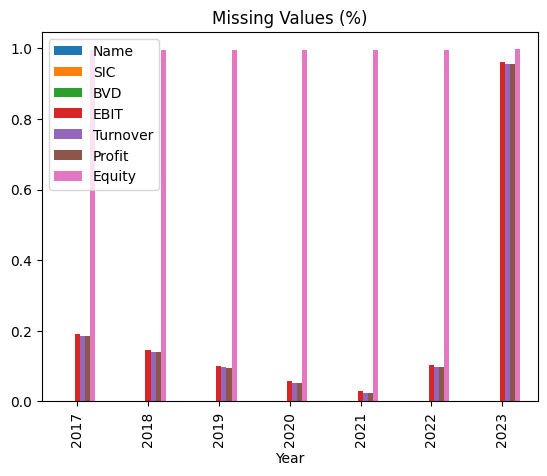

In [5]:
# Visualize Nulls
temp = df.set_index('Year').copy()
temp = temp.isna().astype(float).groupby(temp.index).sum()
temp = temp / (df.shape[0] / 7) # number of observations per year
temp['Year'] = temp.index
temp.plot(x='Year', kind='bar', title='Missing Values (%)')
plt.show()

In [6]:
df = df.drop(columns=['Equity'])          # too many NAs
print(f'Before: {df.shape[0]:,}')
df = df.dropna().reset_index(drop=True)         
print(f'After: {df.shape[0]:,}')
# filter the rest
df.head()

Before: 206,038
After: 159,159


,Name,SIC,BVD,Year,EBIT,Turnover,Profit
0,102 MOTHER CHILD SERVICES (UP),8361.0,IN0020654917,2019,-9.163333,16.424728,-9.335146
1,102 MOTHER CHILD SERVICES (UP),8361.0,IN0020654917,2020,-7.820313,32.540672,-7.995061
2,102 MOTHER CHILD SERVICES (UP),8361.0,IN0020654917,2021,1.128047,44.718649,0.992229
3,102 MOTHER CHILD SERVICES (UP),8361.0,IN0020654917,2022,3.498673,49.819710,3.384219
4,108 EMERGENCY MEDICAL TRANSPORT SERVICES EAST ...,8361.0,IN0020684652,2019,-0.713885,15.468825,-0.837236


## Features Extraction

To conduct the analysis, I need to compute the following 3 metrics:  
- Revenue Growth (% increase compared to previous year)
- Operating Margin (EBIT / Turnover)
- RoE (Profit / Equity)  

However, due to the missing values, I restrict to Revenue Growth (RG) and Operating Margin (OM).

In [7]:
# Operating Margin
df['OM'] = df.EBIT / df.Turnover

# Revenue Growth
df = df.sort_values(by=['Name', 'Year'])
df['RG'] = df.groupby('Name')['Turnover'].apply(lambda x: x.pct_change(fill_method = None)).values

# Set infs to null (companies with turnover == 0)
df = df.replace(np.inf, np.nan)
df = df.replace(-np.inf, np.nan)

print(df.shape)
df.head()

(159159, 9)


,Name,SIC,BVD,Year,EBIT,Turnover,Profit,OM,RG
0,102 MOTHER CHILD SERVICES (UP),8361.0,IN0020654917,2019,-9.163333,16.424728,-9.335146,-0.557899,NaN
1,102 MOTHER CHILD SERVICES (UP),8361.0,IN0020654917,2020,-7.820313,32.540672,-7.995061,-0.240324,0.981200
2,102 MOTHER CHILD SERVICES (UP),8361.0,IN0020654917,2021,1.128047,44.718649,0.992229,0.025225,0.374239
3,102 MOTHER CHILD SERVICES (UP),8361.0,IN0020654917,2022,3.498673,49.819710,3.384219,0.070227,0.114070
4,108 EMERGENCY MEDICAL TRANSPORT SERVICES EAST ...,8361.0,IN0020684652,2019,-0.713885,15.468825,-0.837236,-0.046150,NaN


In [8]:
# Drop all new NAs generated (from OM and RG computation)
df = df.dropna(inplace=False)

# Keep only years 18-19-20-21-22
df = df[df.Year.isin([2018, 2019, 2020, 2021, 2022])]
df.Year.value_counts()

# Discard companies with less than 5 years of data
df = df[df.BVD.isin(df.BVD.value_counts()[df.BVD.value_counts() == 5].index)]

df.Year.value_counts()

Year
2018    20640
2019    20640
2020    20640
2021    20640
2022    20640
Name: count, dtype: int64

Retrieve the major industrial group from the first 2 digits of the SIC code

In [9]:
def lookup(x):
    if 1 <= x <= 9:
        return 'Agriculture, Forestry, and Fishing'
    elif 10 <= x <= 14:
        return 'Mining'
    elif 15 <= x <= 17:
        return 'Construction'
    elif 20 <= x <= 39:
        return 'Manufacturing'
    elif 40 <= x <= 49:
        return 'Transportation, Communications, Electric, Gas, and Sanitary Services'
    elif 50 <= x <= 51:
        return 'Wholesale Trade'
    elif 52 <= x <= 59:
        return 'Retail Trade'
    elif 60 <= x <= 67:
        return 'Finance, Insurance, and Real Estate'
    elif 70 <= x <= 89:
        return 'Services'
    elif 90 <= x <= 99:
        return 'Public Administration'
    else:
        return 'Unknown'

,Name,SIC,BVD,Year,EBIT,Turnover,Profit,OM,RG,Industry
156246,WEST WIND RETAILS PRIVATE LIMITED,5999.0,IN0005000511,2021,0.961388,22.453095,0.580434,0.042818,0.261420,Retail Trade
36494,DORADO CHEM PRIVATE LIMITED,2819.0,IN0007809628,2018,0.697253,2.622423,0.498564,0.265881,0.288162,Manufacturing
61580,ISA LOGISTICS PRIVATE LIMITED,4491.0,IN0003919512,2020,0.319690,4.242564,0.195219,0.075353,0.135245,"Transportation, Communications, Electric, Gas,..."
158456,ZAGGLE PREPAID OCEAN SERVICES LIMITED,6159.0,IN0004794262,2019,0.964844,6.662414,0.421369,0.144819,0.215654,"Finance, Insurance, and Real Estate"
42219,FARE PORTAL INDIA PRIVATE LIMITED,7375.0,IN0002731579,2018,5.863672,53.795086,4.144930,0.109000,0.100659,Services


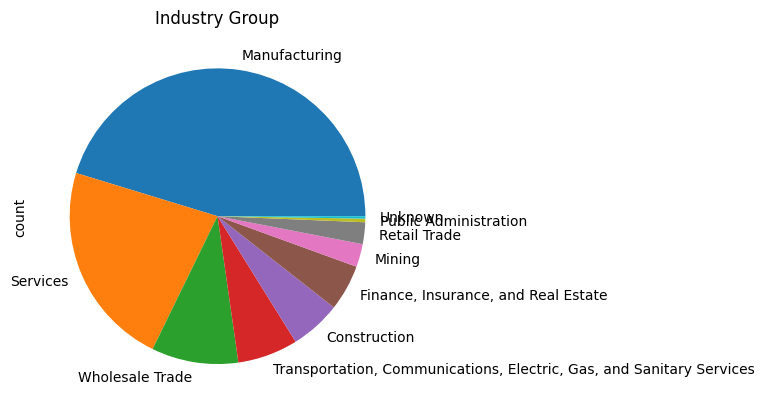

In [10]:
df['Industry'] = df.SIC.astype(str).str[:2].astype(int).apply(lookup)
display(df.sample(5))
df.Industry.value_counts().plot(kind='pie', title='Industry Group')
plt.show()

## Outliers

I will keep all outliers since I am working with the median for now.

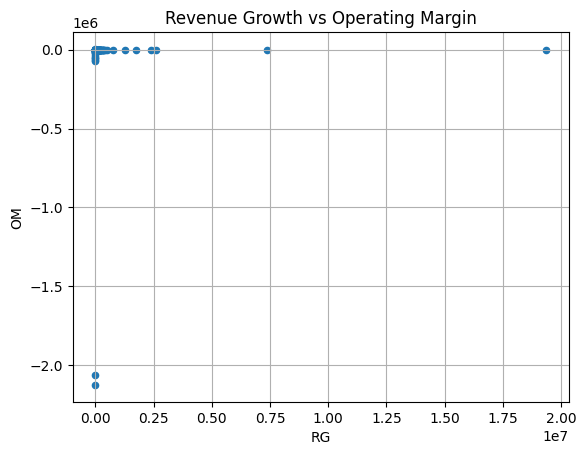

In [11]:
df.plot(x = 'RG', y = 'OM', kind='scatter', title='Revenue Growth vs Operating Margin')
plt.grid()

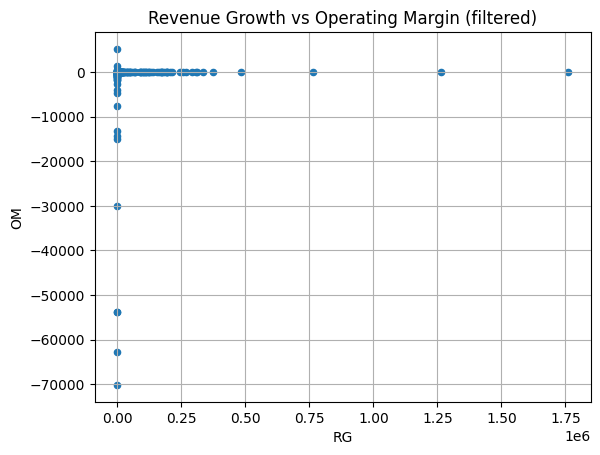

In [12]:
# Drop outliers (not only the entry, but all records for the BVD)
MAX_RG = 0.5e7
MIN_OM = -1e6
df = df[~df.BVD.isin(df[(df.RG > MAX_RG) | (df.OM < MIN_OM)].BVD)]
df.plot(x = 'RG', y = 'OM', kind='scatter', title='Revenue Growth vs Operating Margin (filtered)')
plt.grid()

## Save Processed Dataset

In [21]:
df[['Name', 'BVD', 'Industry']].drop_duplicates()

,Name,BVD,Industry
13,20 MICRONS LTD,IN33942FI,Wholesale Trade
25,20CUBE LOGISTICS SOLUTIONS PRIVATE LIMITED,IN0009503939,Services
40,24/7 CUSTOMER PRIVATE LIMITED,IN0009503096,Services
46,24X7 FACILITY SERVICE CONNECT PRIVATE LIMITED,IN0009502939,Services
61,360 DEGREE CLOUD TECHNOLOGIES PRIVATE LIMITED,IN0002117571,Services
...,...,...,...
159119,ZYDUS TAKEDA HEALTHCARE PRIVATE LIMITED,IN0004780435,Manufacturing
159128,ZYDUS WELLNESS LTD,IN33167FI,Manufacturing
159140,ZYETA INTERIORS PRIVATE LIMITED,IN0004780606,Services
159146,ZYME SOLUTIONS PRIVATE LIMITED,IN0004781492,Services


In [13]:
df.to_csv('./data/orbis_final.csv')

# Resilient Cos Analysis

1. Compute the industry average before and after 2020
2. Identify companies performing above average for both metrics
3. Split into disjoint subsets according to when they are breakway
   1. RESILIENT -> before && after
   2. NON-RESILIENT -> before && ~after
   3. NEW-BREAKAWYS -> ~before && after

In [14]:
breakaway = {}

for time in ['before', 'after']:
    
    # Restrict dataset
    if time == 'before':
        temp = df.loc[df.Year < 2020].copy()
    else:
        temp = df.loc[df.Year > 2020].copy()
    
    # Compute industry average and outer join to the dataset
    industry_avg = temp.groupby('Industry', as_index=False)[['OM', 'RG']].median()
    temp = temp.merge(industry_avg, on='Industry', suffixes=('', '_ind_avg'))
    
    # Flag if above industry average
    temp['OM_above'] = (temp.OM > temp.OM_ind_avg).astype(int)
    temp['RG_above'] = (temp.RG > temp.RG_ind_avg).astype(int)

    # Breakaway iff above industry avg for all years considered and for both metrics
    is_breakaway = temp.groupby('BVD')[['OM_above', 'RG_above']].all().all(axis=1).reset_index().rename(columns={0: f'is_breakaway_{time}'})
    temp = temp.merge(is_breakaway, on='BVD', suffixes=('', ''))
    temp = temp[temp[f'is_breakaway_{time}']].reset_index(drop=True)

    # Store all dataframe
    temp.to_csv(f'./data/breakaway_{time}_2020_all_years.csv', index=False)
    
    # Store list of unique companies by restricting to 2022
    temp = temp[['Name', 'SIC', 'BVD']].drop_duplicates()
    temp.to_csv(f'./data/breakaway_{time}_2020.csv', index=False)
    
    # Save for later
    breakaway[time] = temp.copy()

In [15]:
tmp = df.copy()

tmp.loc[:, 'is_breakaway_before'] = tmp.BVD.isin(breakaway['before'].BVD).to_list()
tmp.loc[:, 'is_breakaway_after'] = tmp.BVD.isin(breakaway['after'].BVD).to_list()

# RESILIENT
resilient = tmp.loc[tmp.is_breakaway_before & tmp.is_breakaway_after, ['Name', 'SIC', 'BVD', 'Industry']].drop_duplicates()
resilient.to_csv('./data/resilient.csv', index=False)
print(f'Resilient are {resilient.shape[0]}')

# NON-RESILIENT
non_resilient = tmp.loc[tmp.is_breakaway_before & ~tmp.is_breakaway_after, ['Name', 'SIC', 'BVD', 'Industry']].drop_duplicates()
non_resilient.to_csv('./data/non_resilient.csv', index=False)
print(f'Non-resilient are {non_resilient.shape[0]}')

# NEW-BREAKAWAY
new_breakaway = tmp.loc[~tmp.is_breakaway_before & tmp.is_breakaway_after, ['Name', 'SIC', 'BVD', 'Industry']].drop_duplicates()
new_breakaway.to_csv('./data/new_breakaway.csv', index=False)
print(f'New breakaway are {new_breakaway.shape[0]}')

Resilient are 479
Non-resilient are 1704
New breakaway are 1717


In [29]:
import os

for file in os.listdir('./data'):
    if file.endswith('.xlsx'):
        print('- '+f'`{file}` ')

- `orbis_raw_15001_31710.xlsx` 
- `orbis_raw_1_15000.xlsx` 
